# Tarefa Numérica 2: Controle Automático de Passo de Integração

**Alexsander Benatti da Silva (14555221)**

**Ana Paula Tavares da Fonseca (8557207)**



- **Parte 1**: Implementação e análise de convergência dos métodos RK3 e RK4 em um problema com solução analítica conhecida

- **Parte 2**: Aplicação dos métodos com controle adaptativo de passo na equação de Van der Pol

## Objetivos

- Implementar métodos RK3 e RK4 para sistemas de EDOs
- Desenvolver estratégia de controle automático de passo baseada em estimativa de erro
- Analisar a convergência numérica através de tabelas de erro

## Bibliotecas necessárias

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Parte 1: Análise de Convergência dos Métodos RK3 e RK4

### Descrição do Problema

Nesta primeira parte, implementamos e analisamos dois métodos de Runge-Kutta de ordens diferentes:

- **RK3 (Runge-Kutta de 3ª ordem)**: Método explícito com erro de truncamento local O(h⁴)
$$
k_1 = f(t,y), \qquad
k_2 = f(t + \frac{h}{2}, y + \frac{h}{2}k_1), \qquad
k_3 = f(t + h, y - hk_1 + 2hk_2)
$$

$$
y_{k+1} = y_k + \frac{h}{6}(k_1 + 4k_2 + k_3)
$$

- **RK4 (Runge-Kutta de 4ª ordem)**: Método clássico com erro de truncamento local O(h⁵)
$$
k_1 = f(t,y), \qquad
k_2 = f(t + \frac{h}{2}, y + \frac{h}{2}k_1), \qquad
k_3 = f(t + \frac{h}{2}, y + \frac{h}{2}k_2), \qquad
k_4 = f(t + h, y + hk_3)
$$

$$
y_{k+1} = y_k + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)
$$

Importante lembrar que, para a criação das tabelas, não foi aplicado o controle automático de passo de integração, pois invalidaria a análise tradicional de convergência que assume passo fixo.

### Problema Teste

Utilizamos o problema de valor inicial:

$$
\begin{cases}
   y'(t) = -2ty(t), \\  
   y(0) = 1
\end{cases}
$$

Este problema possui **solução analítica conhecida**: $y(t) = e^{-t^2}$, o que permite calcular o erro exato e validar a implementação.

### Colunas da Tabela de Convergência

- **n**: Número de passos de integração
- **h**: Tamanho do passo (h = t_final/n)
- **|e(t,h)| (exato)**: Erro absoluto em relação à solução analítica
- **q (exato)**: Razão entre erros consecutivos (erro exato)
- **p* (exato)**: Ordem de convergência estimada (erro exato)
- **|e(t,h)| (estimado)**: Erro estimado usando solução de referência numérica
- **q (estimado)**: Razão entre erros consecutivos (erro estimado)
- **p* (estimado)**: Ordem de convergência estimada (erro estimado)

### Resultados Esperados

- **RK3**: Ordem de convergência próxima a 3
- **RK4**: Ordem de convergência próxima a 4
- **Comparação entre erros**: Comparação entre erro exato e estimado deve mostrar concordância

In [15]:
# Definição do problema de Cauchy com solução exata conhecida
# y' = -2 t y, y(0) = 1 → solução exata: y(t) = exp(-t^2)
def f(t, y):
    return -2 * t * y

def y_exact(t):
    return np.exp(-t**2)

# Implementação de métodos Runge-Kutta

# RK3 clássico (ordem 3)
def rk3_step(t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + (h/2) * k1)
    k3 = f(t + h, y - h * k1 + 2 * h * k2)
    return y + (h/6) * (k1 + 4 * k2 + k3)

# RK4 clássico (ordem 4)
def rk4_step(t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + (h/2) * k1)
    k3 = f(t + h/2, y + (h/2) * k2)
    k4 = f(t + h, y + h * k3)
    return y + (h/6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Função para gerar tabela de convergência de um método dado
def convergence_table(method_step, t_final=0.5, n_values=[4, 8, 16, 32, 64, 128]):
    results = []
    for n in n_values:
        h = t_final / n
        # Calcula solução com passo h
        y_h = 1.0  # condição inicial
        t = 0.0
        for _ in range(n):
            y_h = method_step(t, y_h, h)
            t += h
        
        # Estima y com n=1000
        y_aprox = 1.0
        t = 0.0
        h_aprox = t_final/1000
        for _ in range(1000):
            y_aprox = method_step(t, y_aprox, h_aprox)
            t += h_aprox
        
        # Estimativa de erro usando y aproximado
        e_est = abs(y_h - y_aprox)
        
        # Erro exato
        e_exact = abs(y_h - y_exact(t_final))
        
        results.append((n, h, e_exact, e_est))
    
    # Construir tabela com estimativa de ordem
    table = []
    for i, (n, h, e_exact, e_est) in enumerate(results):
        if i == 0:
            table.append((n, h, e_exact, e_est, np.nan, np.nan, np.nan, np.nan))
        else:
            # Para erro exato
            _, _, e_exact_prev, _ = results[i-1]
            q_exact = abs(e_exact_prev / e_exact)
            p_exact = np.log2(q_exact)
            
            # Para erro estimado
            _, _, _, e_est_prev = results[i-1]
            q_est = abs(e_est_prev / e_est)
            p_est = np.log2(q_est)
            
            table.append((n, h, e_exact, q_exact, p_exact, e_est, q_est, p_est))
    
    df = pd.DataFrame(table, columns=[
        "n", "h", "|e(t,h)| (exato)", "q (exato)", "p* (exato)", 
        "|e(t,h)| (estimado)", "q (estimado)", "p* (estimado)"
    ])
    return df

# Gerar e exibir tabelas para RK3 e RK4
df_rk3 = convergence_table(rk3_step)
df_rk4 = convergence_table(rk4_step)

print("Tabela para RK3:")
display(df_rk3)
print("\nTabela para RK4:")
display(df_rk4)

Tabela para RK3:


,n,h,"|e(t,h)| (exato)",q (exato),p* (exato),"|e(t,h)| (estimado)",q (estimado),p* (estimado)
0,4,0.125000,1.371068e-04,0.000137,NaN,NaN,NaN,NaN
1,8,0.062500,1.605161e-05,8.541623,3.094510,1.605161e-05,8.541627,3.094511
2,16,0.031250,1.942681e-06,8.262607,3.046597,1.942674e-06,8.262636,3.046602
3,32,0.015625,2.389747e-07,8.129234,3.023119,2.389670e-07,8.129464,3.023160
4,64,0.007812,2.963438e-08,8.064104,3.011514,2.962667e-08,8.065942,3.011843
5,128,0.003906,3.689574e-09,8.031925,3.005746,3.681864e-09,8.046650,3.008388



Tabela para RK4:


,n,h,"|e(t,h)| (exato)",q (exato),p* (exato),"|e(t,h)| (estimado)",q (estimado),p* (estimado)
0,4,0.125000,4.523219e-08,4.523219e-08,NaN,NaN,NaN,NaN
1,8,0.062500,3.075462e-09,1.470744e+01,3.878474,3.075460e-09,14.707454,3.878476
2,16,0.031250,3.599920e-10,8.543140e+00,3.094766,3.599898e-10,8.543187,3.094774
3,32,0.015625,2.746348e-11,1.310803e+01,3.712379,2.746126e-11,13.109008,3.712487
4,64,0.007812,1.867284e-12,1.470771e+01,3.878501,1.865064e-12,14.724031,3.880101
5,128,0.003906,1.215694e-13,1.535982e+01,3.941089,1.193490e-13,15.626977,3.965967


## Parte 2: Controle Automático de Passo - Equação de Van der Pol

### Descrição do Problema

A segunda parte implementa uma estratégia de **controle automático de passo** aplicada à equação de Van der Pol, um sistema dinâmico não-linear que apresenta comportamento stiff.

### Equação de Van der Pol
A equação de Van der Pol é uma EDO de segunda ordem:
$$
\frac{d^2y}{dt^2} - μ(1 - y²)\frac{dy}{dt} + y = 0
$$

Convertida para um sistema de primeira ordem:
$$
\begin{cases}
   y₁' &= y₂ \\
   y₂' &= μ(1 - y₁²)y₂ - y₁
\end{cases}
$$

Onde:
- **y₁ = y**: Posição
- **y₂ = y'**: Velocidade
- **μ**: Parâmetro de rigidez (valores maiores → comportamento mais stiff)

A equação de Van der Pol apresenta características interessantes:

- **μ pequeno (μ ≈ 0.1)**: Comportamento quase harmônico
- **μ grande (μ > 1)**: Ciclo limite com regiões stiff
- **Controle adaptativo**: Essencial para capturar mudanças bruscas


### Estratégia de Controle Automático de Passo

#### 1. Estimativa de Erro Local
Utilizamos a **diferença entre RK3 e RK4** como estimativa do erro local:
```python
error = ||y_RK4 - y_RK3||
```

#### 2. Controle Adaptativo
- **Se error > ε**: Reduz o passo (h ← β·h, onde β = 0.5)
- **Se error ≤ ε**: Aceita o passo e avança a solução
- **Critério de parada**: Garante que nunca ultrapasse o tempo final usando ```min(t + h, t_final)```

#### 3. Parâmetros do Algoritmo
- **ε = 10⁻⁶**: Tolerância para erro local
- **β = 0.5**: Fator de redução do passo
- **h_init = 0.5**: Passo inicial

### Implementação

A função `solve_adaptive()` implementa o algoritmo completo:

1. **Inicialização**: Define condições iniciais e passo inicial
2. **Loop principal**: Enquanto t < t_final:
   - Estima erro local
   - Ajusta passo se necessário
   - Avança solução
   - Atualiza tempo (com proteção contra overflow)
3. **Retorno**: Arrays de tempo e solução

In [16]:
# Equação de Van der Pol na forma stiff (sistema de primeira ordem)
def van_der_pol_stiff(t, y, mu):
    y1, y2 = y
    return [y2, mu*(1 - y1**2)*y2 - y1]

# Implementações dos métodos RK3 e RK4 para sistemas
def rk3_system_step(t, y, h, f):
    k1 = f(t, y)
    k2 = f(t + h/2, [y[0] + (h/2)*k1[0], y[1] + (h/2)*k1[1]])
    k3 = f(t + h, [y[0] - h*k1[0] + 2*h*k2[0], y[1] - h*k1[1] + 2*h*k2[1]])
    return [y[0] + (h/6)*(k1[0] + 4*k2[0] + k3[0]), 
            y[1] + (h/6)*(k1[1] + 4*k2[1] + k3[1])]

def rk4_system_step(t, y, h, f):
    k1 = f(t, y)
    k2 = f(t + h/2, [y[0] + (h/2)*k1[0], y[1] + (h/2)*k1[1]])
    k3 = f(t + h/2, [y[0] + (h/2)*k2[0], y[1] + (h/2)*k2[1]])
    k4 = f(t + h, [y[0] + h*k3[0], y[1] + h*k3[1]])
    return [y[0] + (h/6)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0]), 
            y[1] + (h/6)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])]

# Função para estimar o erro local (diferença entre RK3 e RK4)
def estimate_error(t, y, h, f):
    y_rk3 = rk3_system_step(t, y, h, f)
    y_rk4 = rk4_system_step(t, y, h, f)
    return np.linalg.norm(np.array(y_rk3) - np.array(y_rk4))

# Solução com controle automático de passo
def solve_adaptive(method_step, f, y0, t_span, epsilon=1e-6, beta=0.5, h_init=0.5):
    t0, tf = t_span
    t = [t0]
    y = [np.array(y0)]
    h = h_init
    
    while t[-1] < tf:
        current_t = t[-1]
        current_y = y[-1]
        
        # Ajuste do passo para controlar o erro
        error = estimate_error(current_t, current_y, h, f)
        while error > epsilon:
            h *= beta  # Reduz o passo
            error = estimate_error(current_t, current_y, h, f)
        
        # Avança a solução com o passo ajustado
        next_y = method_step(current_t, current_y, h, f)
        
        # Atualiza tempo e solução
        next_t = min(current_t + h, tf)
        t.append(next_t)
        y.append(next_y)
    
    return np.array(t), np.array(y)

In [17]:
# Condições iniciais
y0 = [1.0, 0.0]  # y(0), y'(0)
t_span = [0, 100]  # Intervalo de tempo
mu = 10 # Parâmetro de rigidez

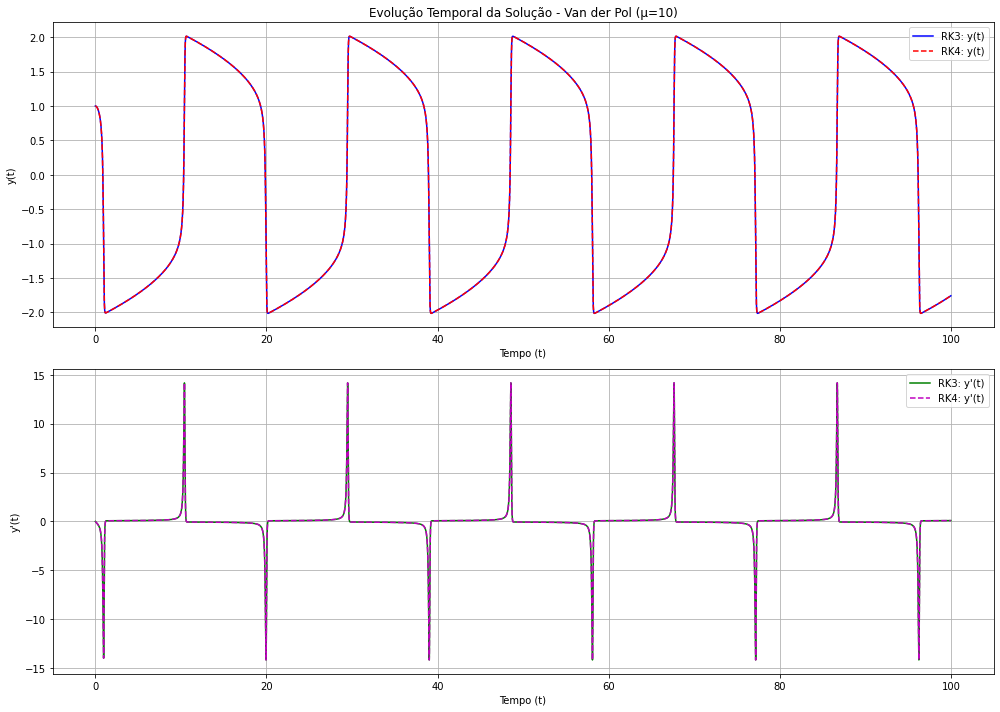

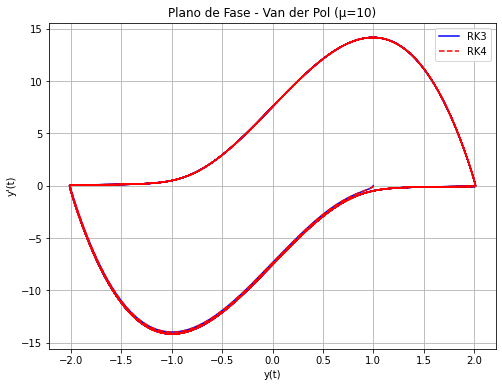

In [18]:
# Resolver com ambos os métodos usando solve_adaptive
t_rk3, y_rk3 = solve_adaptive(rk3_system_step, lambda t, y: van_der_pol_stiff(t, y, mu), y0, t_span)
t_rk4, y_rk4 = solve_adaptive(rk4_system_step, lambda t, y: van_der_pol_stiff(t, y, mu), y0, t_span)

# Criar figura com subplots
plt.figure(figsize=(14, 10))

# Gráfico 1: Evolução de y(t)
plt.subplot(2, 1, 1)
plt.plot(t_rk3, y_rk3[:, 0], 'b-', label='RK3: y(t)')
plt.plot(t_rk4, y_rk4[:, 0], 'r--', label='RK4: y(t)')
plt.title(f'Evolução Temporal da Solução - Van der Pol (μ={mu})')
plt.xlabel('Tempo (t)')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)

# Gráfico 2: Evolução de y'(t)
plt.subplot(2, 1, 2)
plt.plot(t_rk3, y_rk3[:, 1], 'g-', label="RK3: y'(t)")
plt.plot(t_rk4, y_rk4[:, 1], 'm--', label="RK4: y'(t)")
plt.xlabel('Tempo (t)')
plt.ylabel("y'(t)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Gráfico 3: Plano de Fase (y vs y')
plt.figure(figsize=(8, 6))
plt.plot(y_rk3[:, 0], y_rk3[:, 1], 'b-', label='RK3')
plt.plot(y_rk4[:, 0], y_rk4[:, 1], 'r--', label='RK4')
plt.title(f'Plano de Fase - Van der Pol (μ={mu})')
plt.xlabel('y(t)')
plt.ylabel("y'(t)")
plt.legend()
plt.grid(True)
plt.show()